In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, HDBSCAN
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import random
import os


In [67]:
%matplotlib inline
plt.figure(figsize=(10,6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [68]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()


In [69]:
# Prepare data
features = [
    'beam_id',
    'ra_hours',
    'dec_degrees',
    'signal_frequency',
    'signal_beam',
    'signal_drift_rate',
    'signal_snr',
    'signal_power',
    'signal_incoherent_power',
]

pd.set_option('display.max_columns', None)
df = pd.read_pickle("data/clean_df.pkl")
#print(df.head(50))
df_without_incoherent = df[(df.source_name != 'Incoherent')]
df_numeric = df_without_incoherent.select_dtypes(include=[np.number]).fillna(0)
filtered_column_df = df_numeric[features]

In [76]:
def cluster(start_index, end_index, dataframe, seed):
    # set random seeds for consistency
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # take a slice of the original dataframe for clustering (3000 recommended)
    df_subset = dataframe[start_index:end_index]

    # scale the subset dataframe
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_subset)

    # Build autoencoder
    input_dim = X_scaled.shape[1]
    encoding_dim = 4

    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(16, activation='relu')(input_layer)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    decoded = layers.Dense(16, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = models.Model(inputs=input_layer, outputs=decoded)
    encoder = models.Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, shuffle=True, verbose=-1)

    # encode the dataframe subset
    X_encoded = encoder.predict(X_scaled)

    # start clustering
    X = X_encoded

    clusterer = HDBSCAN(
        min_cluster_size=10,
        n_jobs=-1,
    )

    # Fit HDBSCAN
    clusterer.fit(X)
    labels = clusterer.labels_
    probabilities = getattr(clusterer, "probabilities_", None)
    num_outliers = np.count_nonzero(np.where(labels==-1))

    # Project to 2D for visualization
    X_2d = PCA(n_components=2).fit_transform(X)

    # Plot clusters
    plot(X_2d, labels, probabilities=probabilities, parameters={"min_cluster_size":10, "num_outliers":num_outliers})
    plt.show()



# Tracking results of clustering based on random seed for points 0 - 21000 with batch sizes of 3000
Seed = 100:
 - 356
 - 248
 - 566
 - 3
 - 577
 - 1120
 - 1

Seed = 42:
 - 481
 - 280
 - 486
 - 8
 - 412
 - 0
 - 552


Same data different random seed (seed=100 -> seed=42)
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


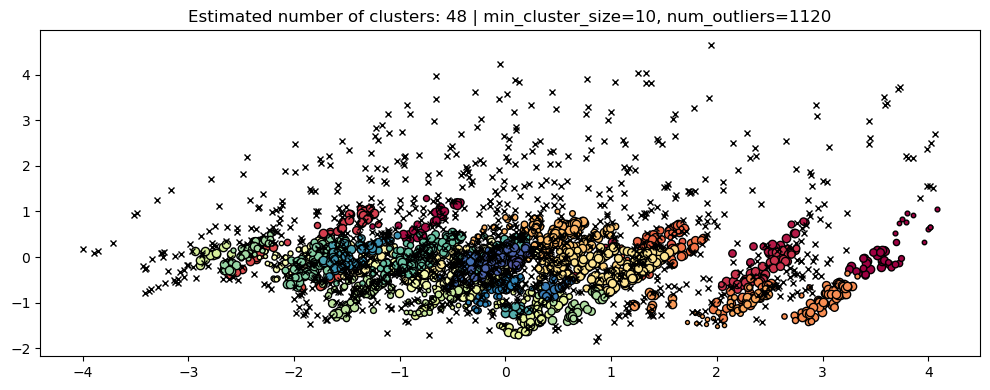

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


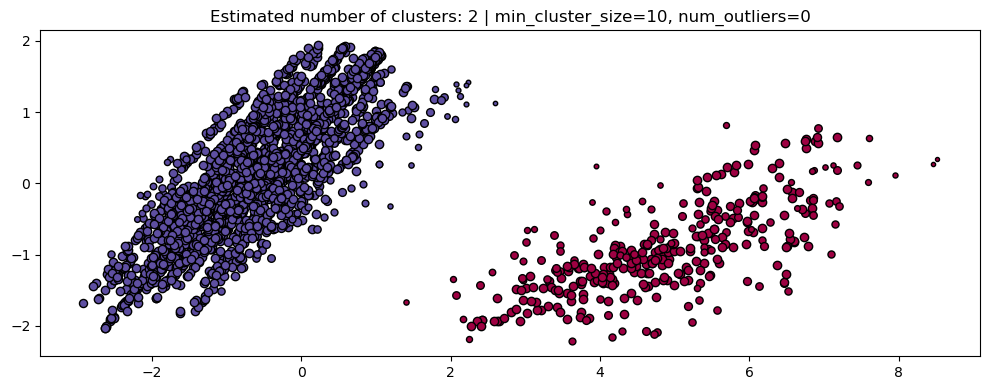

'\nfor i in range(0, 20000, 3000):\n    print(f"Points {i} to {i + 3000}:")\n    cluster(i, i + 3000, filtered_column_df)\n'

In [ ]:
print("Same data different random seed (seed=100 -> seed=42)")
cluster(15000, 18000, filtered_column_df, 100)
cluster(15000, 18000, filtered_column_df, 42)

"""
for i in range(0, 20000, 3000):
    print(f"Points {i} to {i + 3000}:")
    cluster(i, i + 3000, filtered_column_df)
"""
print('', end='')